In [7]:
import tiny_ball_detector as tbd


tbd.models

<module 'tiny_ball_detector.models' from '/home/gaetan/tiny-ball-detector/src/tiny_ball_detector/models/__init__.py'>

tf.Tensor(
[[  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   1   2   1   0   0   0   0]
 [  0   0   0   4  20  34  20   4   0   0   0]
 [  0   0   1  20  93 154  93  20   1   0   0]
 [  0   0   2  34 154 255 154  34   2   0   0]
 [  0   0   1  20  93 154  93  20   1   0   0]
 [  0   0   0   4  20  34  20   4   0   0   0]
 [  0   0   0   0   1   2   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]], shape=(11, 11), dtype=uint8)


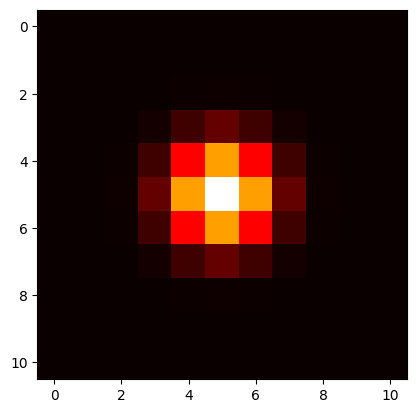

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


def gaussian_kernel(size, variance):
    x, y = tf.meshgrid(
        tf.range(-size, size + 1, dtype=tf.float32),
        tf.range(-size, size + 1, dtype=tf.float32),
    )
    g = tf.exp(-(x**2 + y**2) / float(2 * variance))
    return g


def create_gaussian(size, variance):
    gaussian_kernel_array = gaussian_kernel(size, variance)
    gaussian_kernel_array = gaussian_kernel_array * 255
    gaussian_kernel_array = tf.cast(gaussian_kernel_array, dtype=tf.uint8)
    return gaussian_kernel_array


print(create_gaussian(5, 1))
plt.imshow(create_gaussian(5, 1), cmap="hot", interpolation="nearest")

In [1]:
%load_ext autoreload
%autoreload 1

In [3]:
import os
import tensorflow as tf

In [1]:
from logging import DEBUG
import logging
from pathlib import Path
from tiny_ball_detector.dataset.tracknet_dataset import TrackNetDatasetLoader

logger = logging.getLogger("FrameGeneratorLogger")

data = TrackNetDatasetLoader(path=Path("../data/tennis"), n_frames=3, logger=logger)

2025-02-14 00:40:01.074976: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-14 00:40:01.083663: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739490001.093808   65598 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739490001.096685   65598 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-14 00:40:01.107515: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


I0000 00:00:1739490002.327597   65598 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9635 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:05:00.0, compute capability: 8.6


In [2]:
data(size=20, variance=10)

📌 Number of clips found: 95


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.
10 tf.Tensor([159], shape=(1,), dtype=int32) tf.Tensor([479], shape=(1,), dtype=int32) 0 0 0 0 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
10 tf.Tensor([124], shape=(1,), dtype=int32) tf.Tensor([485], shape=(1,), dtype=int32) 0 0 0 0 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
10 tf.Tensor([108], shape=(1,), dtype=int32) tf.Tensor([490], shape=(1,), dtype=int32) 0 0 0 0 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
10 tf.Tensor([106], shape=(1,), dtype=int32) tf.Tensor([497], shape=(1,), dtype=int32) 0 0 0 0 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


2025-02-14 00:40:02.772233: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<_FlatMapDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), {'file name': TensorSpec(shape=(1,), dtype=tf.string, name=None), 'visibility': TensorSpec(shape=(1,), dtype=tf.int32, name=None), 'x-coordinate': TensorSpec(shape=(1,), dtype=tf.int32, name=None), 'y-coordinate': TensorSpec(shape=(1,), dtype=tf.int32, name=None), 'status': TensorSpec(shape=(1,), dtype=tf.int32, name=None)})>

In [6]:
for i in data.take(1):
    print(i)

(<tf.Tensor: shape=(3, 1280, 720, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],




2025-02-12 00:48:50.075196: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
gaussian_kernel_array = create_gaussian(20, 10)
gaussian_kernel_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [2]:
for i in data.take(1):
    print(i)

(<tf.Tensor: shape=(3, 1280, 720, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],




2025-02-12 00:32:02.122840: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
